In [1]:
import os
import sys
import h5py
import glob

import numpy as np

import vaex
import mpl_scatter_density
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.style.use('seaborn-colorblind')
mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 6))

In [2]:
sim_dir = '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/'
sim_files = sorted(glob.glob(os.path.join(sim_dir, '*.hdf5')))
sim_files

['/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/lsr-0-rslice-0.m12i-res7100-subsamples.hdf5',
 '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/lsr-0-rslice-1.m12i-res7100-subsamples.hdf5',
 '/scratch/08317/tg876168/ananke_subsamples/m12i/lsr-0/lsr-0-rslice-2.m12i-res7100-subsamples.hdf5']

In [3]:
for i_file in range(len(sim_files)):
    with h5py.File(sim_files[i_file], 'r') as f:
        print(list(f.keys()))
        print(f['ra'].len())

['dec', 'feh', 'labels', 'parallax', 'parallax_over_error', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
50683177
['dec', 'feh', 'labels', 'parallax', 'parallax_over_error', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
13581
['dec', 'feh', 'labels', 'parallax', 'parallax_over_error', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
2


In [4]:
def subsample_data(sim_file, keys, subsample_factor=100, batch_size=100000, seed=None):

    # set random seed 
    np.random.seed(seed)

    n_batch_sample = batch_size // subsample_factor

    data = {}
    with h5py.File(sim_file, 'r') as input_f:
        n_total = input_f['ra'].len()
        slices = np.arange(n_total + batch_size, step=batch_size)

        # start slicing input data
        for i in range(len(slices) - 1):
            start = slices[i]
            stop = slices[i + 1]
            # dealing with last slice
            if stop > n_total:
                stop = n_total
                batch_size = stop - start
                n_batch_sample = batch_size // subsample_factor
            
            # randomly sample data and add properties to data dict
            rand = np.random.permutation(batch_size)[:n_batch_sample]
            for p in keys:
                if data.get(p) is None:
                    data[p] = []
                data[p].append(input_f[p][start: stop][rand])

    # convert values into numpy array
    for p in keys:
        data[p] = np.concatenate(data[p])
    
    return data

In [5]:
keys = ('feh', 'px_true', 'py_true', 'pz_true', 'vx_true', 'vy_true', 'vz_true', 'labels', )
subsample_factor = 1

data = []
if subsample_factor > 1:
    seed = 631346    
    data = subsample_data(
        sim_files[0], keys, subsample_factor=subsample_factor, seed=seed)
else:
    data = {}
    with h5py.File(sim_files[0], 'r') as input_f:
        for p in keys:
            data[p] = input_f[p][:]

In [18]:
# get properties
feh = data['feh']
labels = data['labels']
x_lsr = data['px_true']
y_lsr = data['py_true']
z_lsr = data['pz_true']
vx_lsr = data['vx_true']
vy_lsr = data['vy_true']
vz_lsr = data['vz_true']

# perp velocity w.r.t LSR
vperp_lsr = np.sqrt(vx_lsr**2 + vz_lsr**2)

# phase-space coordinate of LSR
x0_lsr, y0_lsr, z0_lsr = 0.0, 8.2, 0.0
vx0_lsr, vy0_lsr, vz0_lsr = 224.7092, -20.3801, 3.8954

In [37]:
# convert to Galactic coordinate
# rotate LSR coordinates
# mock convention: x points from LSR to gal center; y points in solar rotation  
# sim convention: x points in solar rotation; y points from gal center to LSR
x_lsr_sim = y_lsr
y_lsr_sim = -x_lsr
z_lsr_sim = z_lsr
vx_lsr_sim = vy_lsr
vy_lsr_sim = -vx_lsr
vz_lsr_sim = vz_lsr

# convert to Galactic Cartesian
x_gal = x_lsr_sim + x0_lsr
y_gal = y_lsr_sim + y0_lsr
z_gal = z_lsr_sim + z0_lsr
vx_gal = vx_lsr_sim + vx0_lsr
vy_gal = vy_lsr_sim + vy0_lsr
vz_gal = vz_lsr_sim + vz0_lsr

# convert to Galactic Cylindrical
# NOTE: vphi has a negative sign because the angular momentum is in -Z
r_gal = np.sqrt(x_gal**2 + y_gal**2)
vr_gal = (x_gal*vx_gal + y_gal * vy_gal) / r_gal
vphi_gal = -(x_gal*vy_gal - y_gal*vx_gal) / r_gal

In [22]:
# get index of insitu and accreted stars
mask_insitu = (labels == 0)
n_insitu = np.sum(mask_insitu)
n_accreted = np.sum(~mask_insitu)

print('Number of in situ stars: {:d}'.format(n_insitu))
print('Number of accreted stars: {:d}'.format(n_accreted))

Number of in situ stars: 50293592
Number of accreted stars: 389585


Scatterplot a large number of data points is time-consuming, so we further subsample the dataset into a plotting dataset.

In [23]:
subsample_plot = 100
if subsample_plot > 1:
    rand_insitu = np.random.permutation(n_insitu)[:n_insitu // subsample_plot]
    rand_accreted = np.random.permutation(n_accreted)[:n_accreted // subsample_plot]
    print('Number of in situ stars plotting sample: {:d}'.format(len(rand_insitu)))
    print('Number of accreted stars plotting sample: {:d}'.format(len(rand_accreted)))
else:
    rand_insitu = ()
    rand_accreted = ()

Number of in situ stars plotting sample: 502935
Number of accreted stars plotting sample: 3895


### Distribution

First, we plot the distributions of each propery of in situ and accreted stars. Plotting histogram is fast, so we do not need to subsample the dataset.

1. Plot metallicity [Fe/H] distribution for in situ and accreted stars

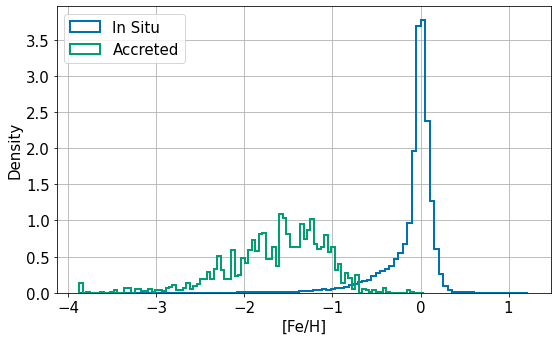

In [38]:
# plot [Fe / H] histogram for in situ and accreted stars
fig, ax = plt.subplots(1, figsize=(8, 5))

# bins = np.arange(-4., 1.5, 0.125)
bins = 100
ax.hist(feh[mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='In Situ')
ax.hist(feh[~mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='Accreted')

# format axes and figure
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.grid(True)
ax.legend(loc=2)

fig.tight_layout()
fig.savefig('plots/feh.png', bbox_inches='tight')

2. Plot the phase space distribution for in situ and accreted stars

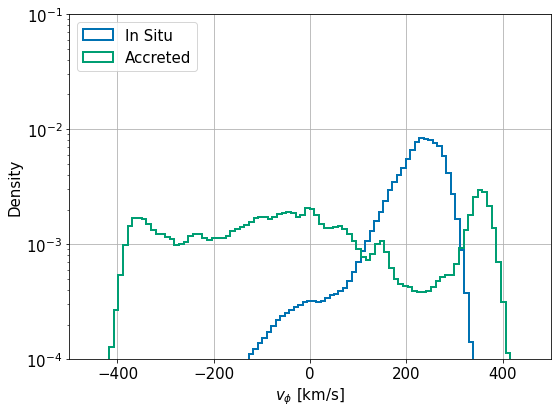

In [50]:
fig, ax = plt.subplots(1)

bins = 100
ax.hist(vphi_gal[mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='In Situ')
ax.hist(vphi_gal[~mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='Accreted')

# format axes and figure
ax.set_xlabel(r'$v_\phi$ [km/s]')
ax.set_ylabel('Density')
ax.set_xlim(-500, 500)
ax.set_ylim(1e-4, 1e-1)
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc=2)

fig.tight_layout()
fig.savefig('plots/vphi.png', bbox_inches='tight')

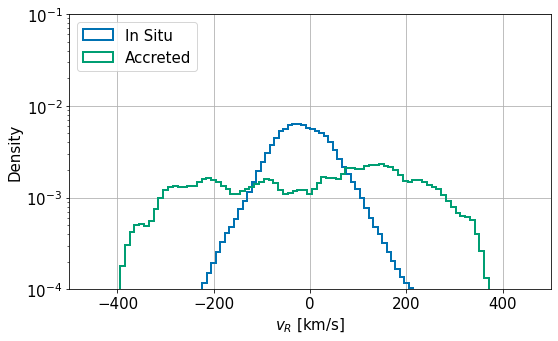

In [51]:
fig, ax = plt.subplots(1, figsize=(8, 5))

# bins = np.arange(-4., 1.5, 0.125)
bins = 100
ax.hist(vr_gal[mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='In Situ')
ax.hist(vr_gal[~mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='Accreted')

# format axes and figure
ax.set_xlabel(r'$v_R$ [km/s]')
ax.set_ylabel('Density')
ax.set_xlim(-500, 500)
ax.set_ylim(1e-4, 1e-1)
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc=2)

fig.tight_layout()
fig.savefig('plots/vr.png', bbox_inches='tight')

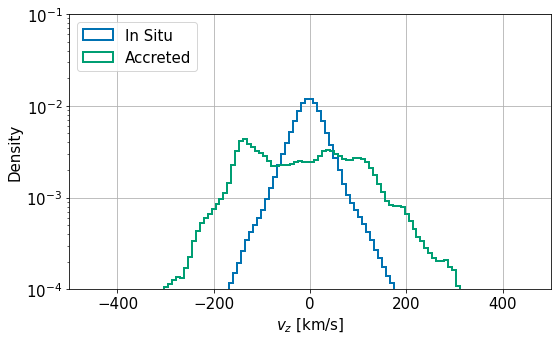

In [52]:
fig, ax = plt.subplots(1, figsize=(8, 5))

# bins = np.arange(-4., 1.5, 0.125)
bins = 100
ax.hist(vz_gal[mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='In Situ')
ax.hist(vz_gal[~mask_insitu], bins, density=True, 
        histtype='step', lw=2, label='Accreted')

# format axes and figure
ax.set_xlabel(r'$v_z$ [km/s]')
ax.set_ylabel('Density')
ax.set_xlim(-500, 500)
ax.set_ylim(1e-4, 1e-1)
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc=2)

fig.tight_layout()
fig.savefig('plots/vz.png', bbox_inches='tight')

Plot phase space scatterplots for in situ and accreted stars 

1. Plot the scatterplot of the vertical distance $z$ versus metallicity [Fe/H]

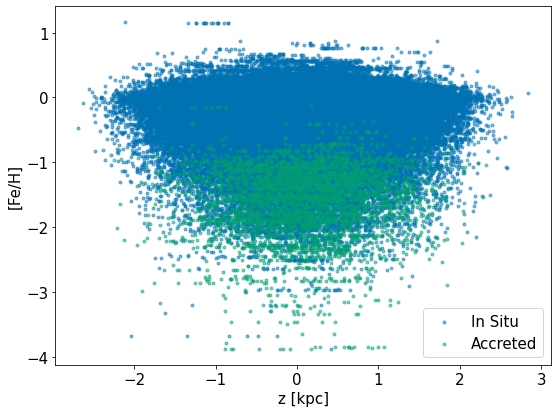

In [53]:
fig, ax = plt.subplots(1)

ax.scatter(
    z_lsr[mask_insitu][rand_insitu], feh[mask_insitu][rand_insitu],
    marker='.', alpha=0.5, label='In Situ')
ax.scatter(
    z_lsr[~mask_insitu][rand_accreted], feh[~mask_insitu][rand_accreted],
    marker='.', alpha=0.5, label='Accreted')

ax.set_xlabel('z [kpc]')
ax.set_ylabel('[Fe/H]')
ax.legend(loc=0)

fig.tight_layout()
fig.savefig('plots/z_feh.png', bbox_inches='tight')

2. Plot the scatterplot of azimuthal velocity $v_\phi$ versus the metallicity [Fe/H]

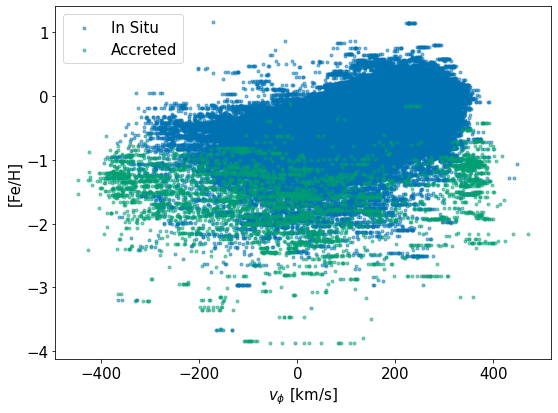

In [73]:
fig, ax = plt.subplots(1)

ax.scatter(
    vphi_gal[mask_insitu][rand_insitu], feh[mask_insitu][rand_insitu], 
    marker='.', alpha=0.5, label='In Situ')
ax.scatter(
    vphi_gal[~mask_insitu][rand_accreted], feh[~mask_insitu][rand_accreted],
    marker='.', alpha=0.5, label='Accreted')

ax.set_xlabel(r'$v_\phi$ [km/s]')
ax.set_ylabel('[Fe/H]')
ax.legend(loc=0)

fig.tight_layout()
# fig.savefig('plots/vphi_feh.png', bbox_inches='tight')

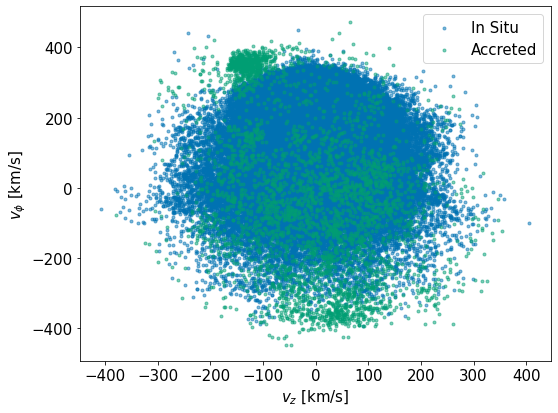

In [54]:
fig, ax = plt.subplots(1)

ax.scatter(
    vz_gal[mask_insitu][rand_insitu], vphi_gal[mask_insitu][rand_insitu],
    marker='.', alpha=0.5, label='In Situ')
ax.scatter(
    vz_gal[~mask_insitu][rand_accreted], vphi_gal[~mask_insitu][rand_accreted],
    marker='.', alpha=0.5, label='Accreted')

ax.set_xlabel(r'$v_z$ [km/s]')
ax.set_ylabel(r'$v_\phi$ [km/s]')
ax.legend(loc=0)

fig.tight_layout()
# fig.savefig('plots/toomre.png', bbox_inches='tight')

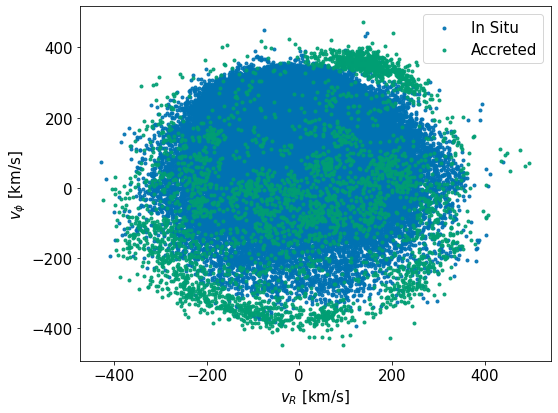

In [57]:
fig, ax = plt.subplots(1)

ax.scatter(
    vr_gal[mask_insitu][rand_insitu], vphi_gal[mask_insitu][rand_insitu],
    marker='.', alpha=0.3, label='In Situ')
ax.scatter(
    vr_gal[~mask_insitu][rand_accreted], vphi_gal[~mask_insitu][rand_accreted],
    marker='.', alpha=0.3, label='Accreted')

ax.set_xlabel(r'$v_R$ [km/s]')
ax.set_ylabel(r'$v_\phi$ [km/s]')
ax.legend(loc=0)

fig.tight_layout()
# fig.savefig('plots/toomre.png', bbox_inches='tight')

Plot heatmap

In [69]:
df = vaex.from_arrays(
    vx_lsr=vx_lsr, vy_lsr=vy_lsr, vz_lsr=vz_lsr, vperp_lsr=vperp_lsr,
    vr_gal=vr_gal, vphi_gal=vphi_gal, vz_gal=vz_gal,
    feh=feh, labels=labels)

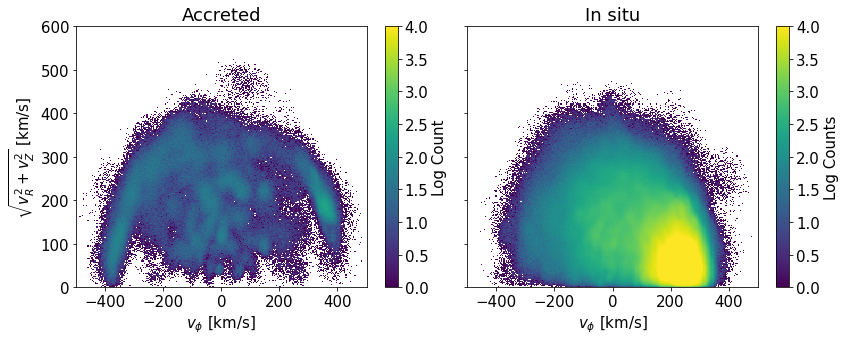

In [72]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, sharex=True, sharey=True, figsize=(12, 5))

plt.sca(ax1)
im = df.viz.heatmap(
    df.vphi_gal, np.sqrt(df.vr_gal**2 + df.vz_gal**2),
    xlabel=r'$v_\phi$ [km/s]', ylabel=r'$\sqrt{v_R^2 + v_Z^2}$ [km/s]', 
    selection=[df.labels==1],
    colorbar_label='Log Count', colormap='viridis',
    vmin=0, vmax=4, f='log10',
    limits=[(-500, 500), (0, 600)],
)
plt.title('Accreted')

plt.sca(ax2)
df.viz.heatmap(
    df.vphi_gal, np.sqrt(df.vr_gal**2 + df.vz_gal**2),
    xlabel=r'$v_\phi$ [km/s]',
    selection=[df.labels==0],
    colorbar_label='Log Counts', colormap='viridis',
    vmin=0, vmax=4, f='log10',
    limits=[(-500, 500), (0, 600)],
)
plt.title('In situ')

fig.tight_layout()
fig.savefig('plots/toomre_heatmap_gal.png', bbox_inches='tight')

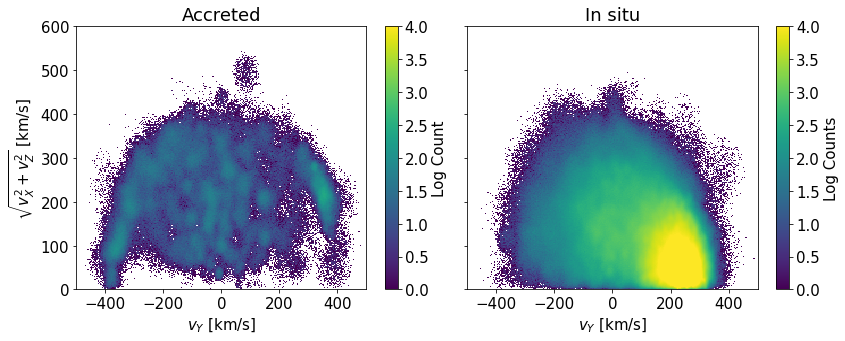

In [71]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, sharex=True, sharey=True, figsize=(12, 5))

plt.sca(ax1)
im = df.viz.heatmap(
    df.vy_lsr + vx0_lsr, df.vperp_lsr,
    xlabel=r'$v_Y$ [km/s]', ylabel=r'$\sqrt{v_X^2 + v_Z^2}$ [km/s]', 
    selection=[df.labels==1],
    colorbar_label='Log Count', colormap='viridis',
    vmin=0, vmax=4, f='log10',
    limits=[(-500, 500), (0, 600)],
)
plt.title('Accreted')

plt.sca(ax2)
df.viz.heatmap(
    df.vy_lsr + vx0_lsr, df.vperp_lsr,
    xlabel=r'$v_Y$ [km/s]', 
    selection=[df.labels==0],
    colorbar_label='Log Counts', colormap='viridis',
    vmin=0, vmax=4, f='log10',
    limits=[(-500, 500), (0, 600)],
)
plt.title('In situ')

fig.tight_layout()
fig.savefig('plots/toomre_heatmap_LSR.png', bbox_inches='tight')

In [90]:
# fig, (ax1, ax2) = plt.subplots(
#     1, 2, sharex=True, sharey=True, figsize=(1 2, 5))

# plt.sca(ax1)
# im = df.viz.heatmap(
#     'vz_true', 'vphi_true',
#     xlabel=r'$v_y$ [km/s]', ylabel=r'$\sqrt{v_x^2 + v_z^2}$ [km/s]', 
#     selection=[df.labels==1],
#     colorbar_label='Log Count', colormap='viridis',
#     vmin=0, vmax=4, f='log10',
#     limits=[(-500, 500), (-500, 500)],
# )
# plt.title('Accreted')

# plt.sca(ax2)
# df.viz.heatmap(
#     'vz_true', 'vphi_true',
#     xlabel=r'$v_y$ [km/s]', ylabel=r'$\sqrt{v_x^2 + v_z^2}$ [km/s]', 
#     selection=[df.labels==0],
#     colorbar_label='Log Counts', colormap='viridis',
#     vmin=0, vmax=4, f='log10',
#     limits=[(-500, 500), (-500, 500)],
# )
# plt.title('In situ')

# fig.tight_layout()
# # fig.savefig('plots/toomre_heatmap.png', bbox_inches='tight')